# Diffusion

shape of s: (10000, 2)


(-0.14680346230100003,
 0.14390273370978754,
 -0.2555611392653503,
 0.2593984574796788)

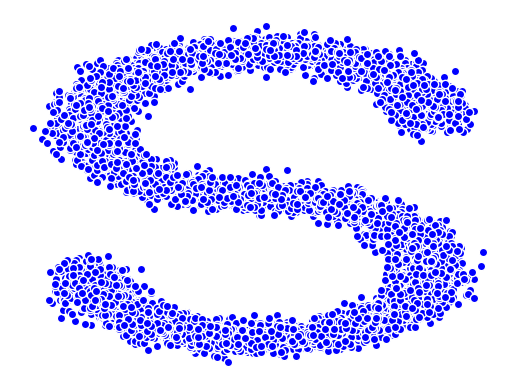

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:,  [0, 2]]/10.0

print("shape of s:", np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='blue', edgecolor='white');

ax.axis('off')

## Hyper Parameter

$\alpha_t = 1 - \beta_t$

$\overline{\alpha}_t = \alpha_1\alpha_2...\alpha_t$


In [15]:
num_steps = 100

betas = np.linspace(-6, 6, num_steps)
betas = 1 / (1 + np.exp(-betas))    # sigmoid
betas = betas * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = np.cumprod(alphas, 0)
alphas_prod_p = np.concatenate((np.array([1.0]), alphas_prod[:-1]), axis=0)
alphas_bar_sqrt = np.sqrt(alphas_prod)

one_minus_alphas_bar_log = np.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = np.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape ==\
    alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape\
    == one_minus_alphas_bar_sqrt.shape

print("all the same shape", betas.shape)

all the same shape (100,)


## Q-Sample

$x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha}_t}\epsilon$

In [16]:
def q_x(x_0, t):
    noise = np.random.randn(*x_0.shape)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]

    return (alphas_t * x_0 + alphas_1_m_t * noise)

### q-sample examples

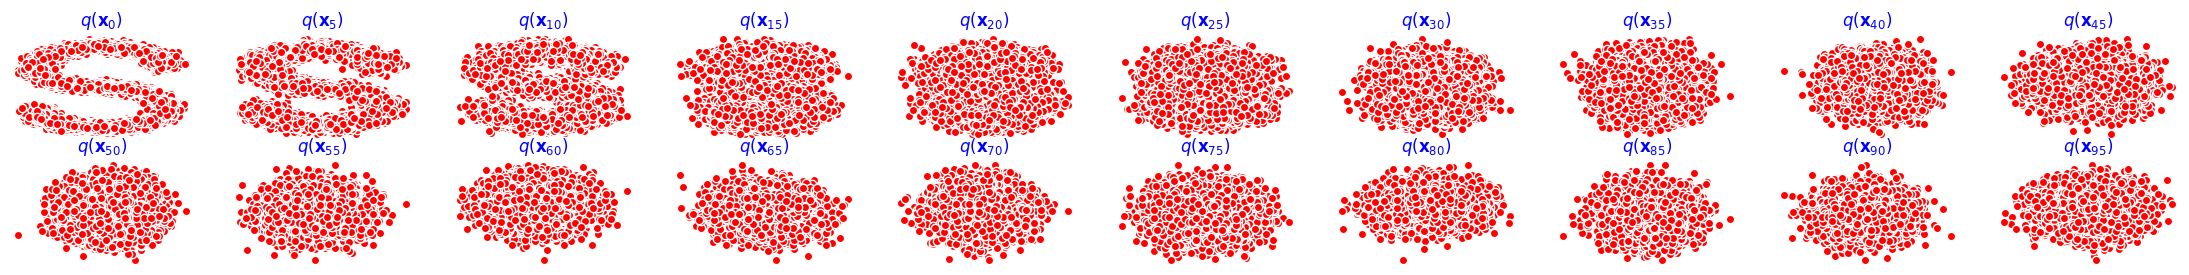

In [17]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='black')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(s_curve, i*num_steps//num_shows)
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

## Model

In [18]:
from dazero import Model
import dazero.layers as L
import dazero.functions as F
from dazero.models import Sequential


class Diffusion(Model):
    def __init__(self, num_steps, num_units=128):
        super().__init__()
        self.linears = [
            L.Linear(2, num_units),
            F.relu,
            L.Linear(num_units, num_units),
            F.relu,
            L.Linear(num_units, num_units),
            F.relu,
            L.Linear(num_units, 2)
        ]
        self.step_embeddings = Sequential(
            L.Embedding(num_steps, num_units),
            L.Embedding(num_steps, num_units),
            L.Embedding(num_steps, num_units)
        )

    def forward(self, x, t):
        # x = x_0
        for idx, embed in enumerate(self.step_embeddings):
            t_embed = embed(t)
            x = self.linears[2 * idx](x)
            x += t_embed
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)
        return x

## Loss Function

$$
\begin{aligned}
& \mathbf{Repeat}: \\
& ~~~~~~~~  x_0 ∼ q(x_0)    \\
& ~~~~~~~~  t ∼ Uniform({1, . . . , T}) \\
& ~~~~~~~~  \epsilon ∼ N (0, I) \\
& ~~~~~~~~  Take~gradient~descent~step~on:  \\
& ~~~~~~~~  ~~~~~~~~ ∇_θ\big||\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha}_t}\epsilon, t)|\big|^2    \\
& \mathbf{Until}~converged
\end{aligned}
$$

In [19]:
def loss_fn(model, x_0, alphas_bar_sqrt,  one_minus_alphas_bar_sqrt,  n_steps):
    batch_size = x_0.shape[0]

    t = np.random.randint(0, n_steps, size=(batch_size // 2,))
    t = np.concatenate([t, n_steps - 1 - t], axis=0)
    t = t[:, np.newaxis]

    a = alphas_bar_sqrt[t]
    aml = one_minus_alphas_bar_sqrt[t]
    e = np.random.randn(*x_0.shape)

    x = x_0 * a + e * aml
    output = model(x, np.squeeze(t, axis=-1))

    return F.mse_loss(e, output)

## Inference

$$
\begin{aligned}
& x_T ∼ N (0, I)\\
& \mathbf{for}~t = T, ..., 1~\mathbf{do}\\
& ~~~~~~~~ z ∼ N (0, I)~~~~if~t > 1,~else~z = 0\\
& ~~~~~~~~ x_{t−1} = \frac{1}{\sqrt{\alpha_t}}\big( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \overline{\alpha_t}}}\epsilon_\theta(x_t, t) + \sigma_t z \big)\\
& \mathbf{end~for}\\
& \mathbf{return}~x_0
\end{aligned}
$$

In [20]:
def p_sample_loop(model, shape, num_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = np.random.rand(*shape)
    x_seq = [cur_x]
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x.data)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = np.array([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (np.sqrt(alphas[t]))) * (x - (coeff * eps_theta))

    z = np.random.randn(*x.shape)
    sigma_t = np.sqrt(betas[t])

    sample = mean + sigma_t * z
    return sample

## Train

Training model...
epoch: 0	2.7050848761797326
epoch: 100	1.3186001454856908
epoch: 200	1.2053242771632169
epoch: 300	0.984600489545178
epoch: 400	1.412398744448866
epoch: 500	0.9165143955809787
epoch: 600	0.9478026513703862
epoch: 700	0.544398967204694
epoch: 800	0.5999967466561258
epoch: 900	1.6132513272459423
epoch: 1000	1.1896688818582002
epoch: 1100	0.49007710025875945
epoch: 1200	0.9667339605946402
epoch: 1300	1.7334039346474979
epoch: 1400	1.2762427906587948
epoch: 1500	1.1376419001333637
epoch: 1600	1.6502892929278294
epoch: 1700	0.8870251098845364
epoch: 1800	0.7055218920422345
epoch: 1900	0.7016639192009573
epoch: 2000	1.1332741397731043
epoch: 2100	1.1310749259955348
epoch: 2200	1.072652983389835
epoch: 2300	0.9202303931060061
epoch: 2400	0.9224068073422347
epoch: 2500	0.9139810155926704
epoch: 2600	0.6473619454113416
epoch: 2700	1.000302012551641
epoch: 2800	1.584812230355304
epoch: 2900	1.306656821985174
epoch: 3000	1.734716067016292
epoch: 3100	0.8993412623769683
epoch: 32

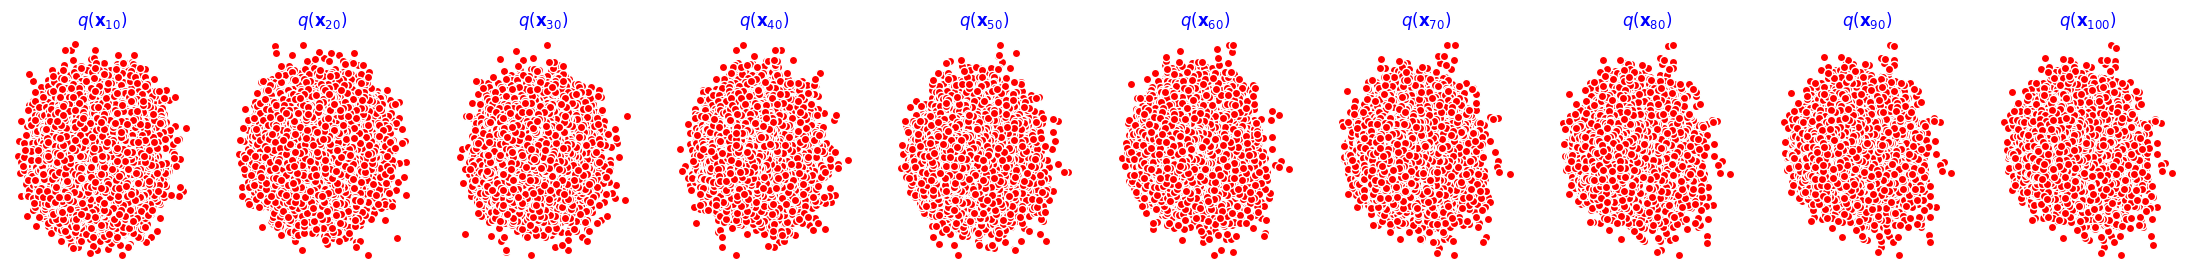

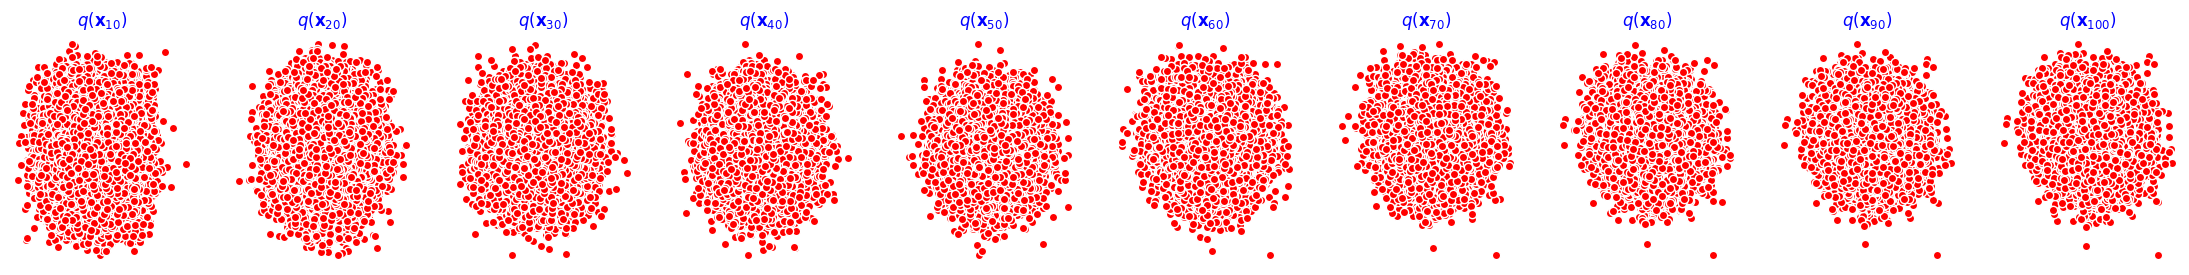

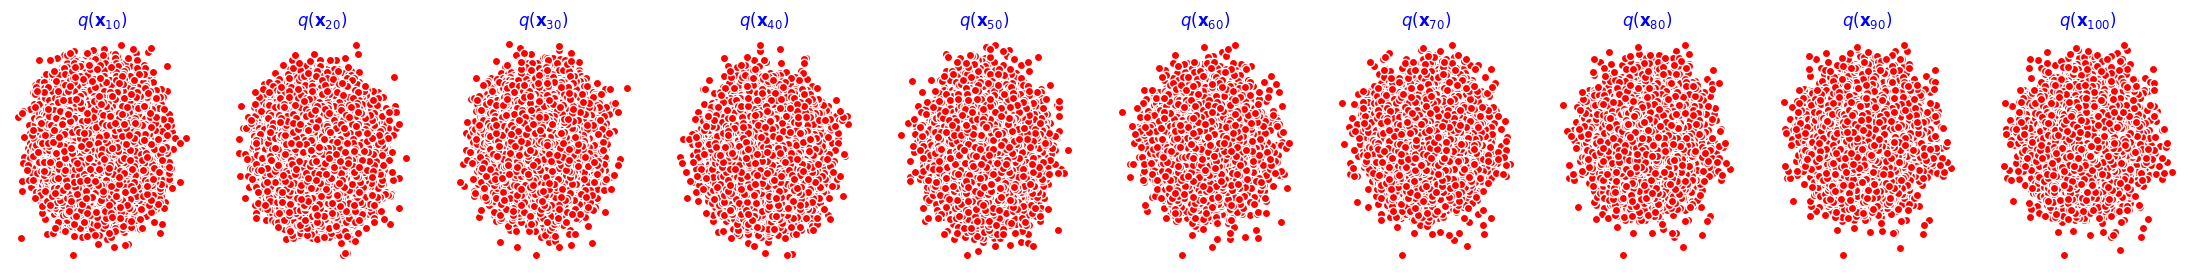

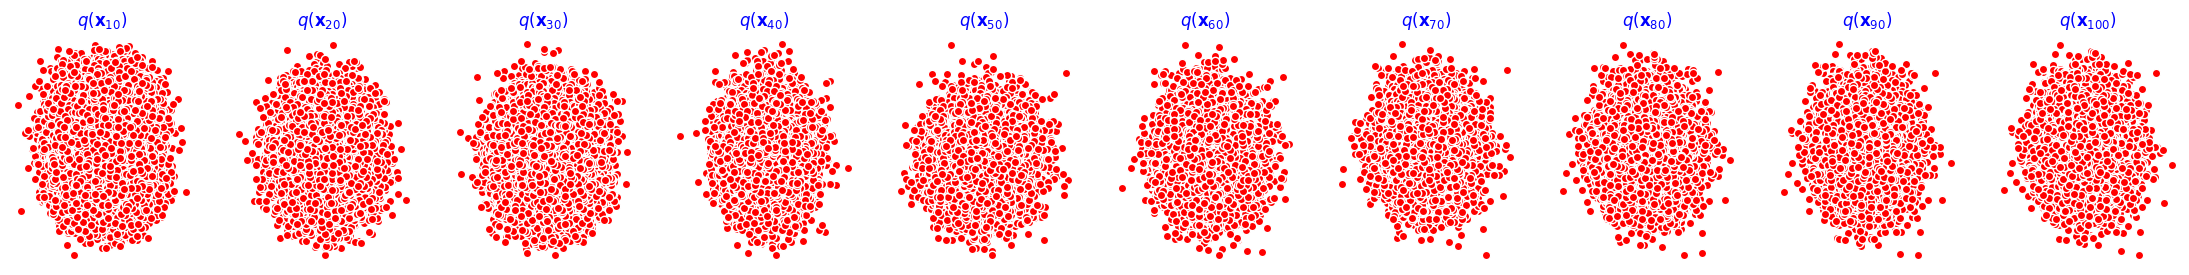

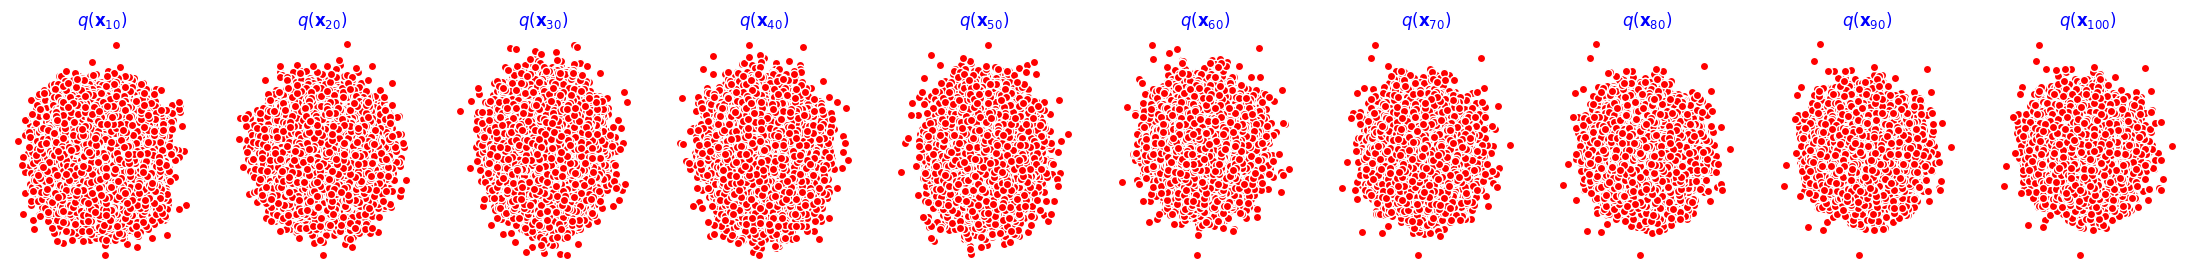

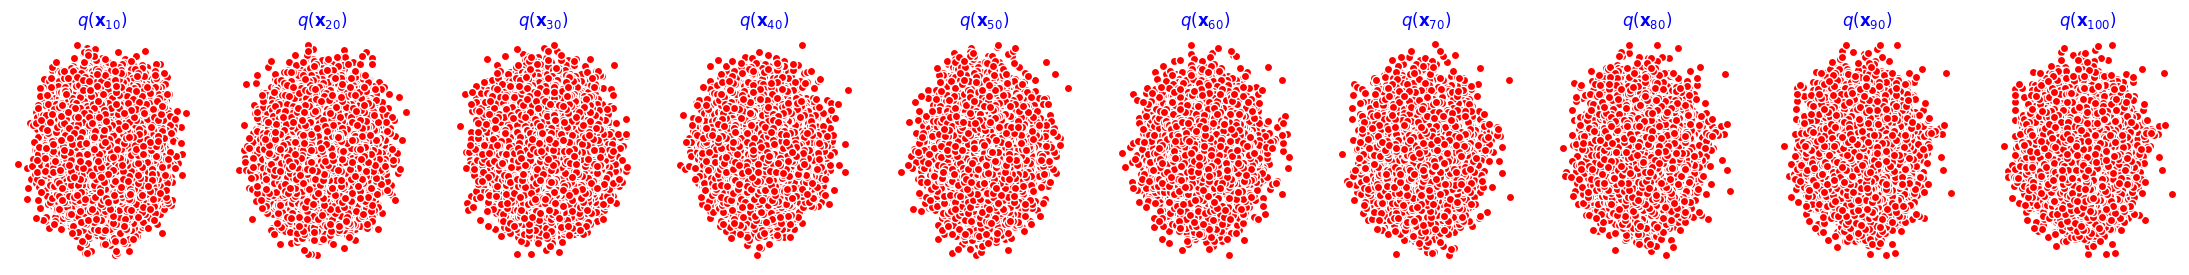

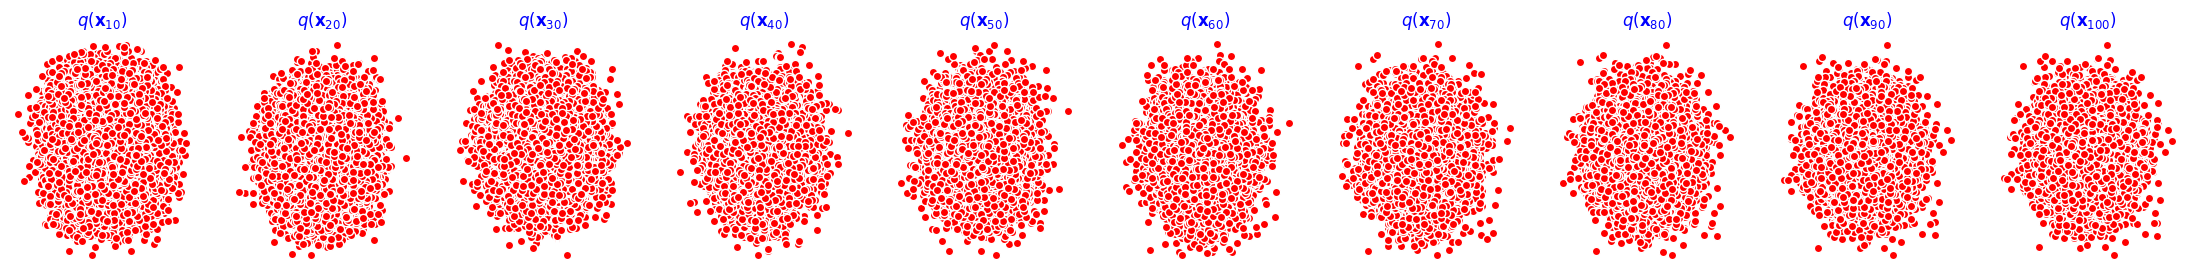

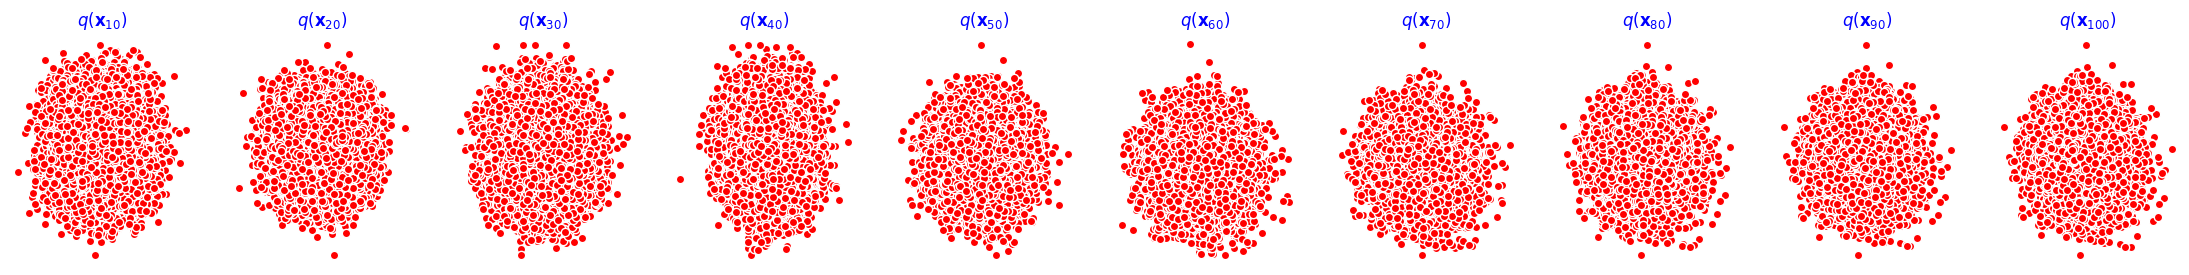

In [21]:
from dazero.optimizers import Adam
from dazero.dataloaders import DataLoader, Dataset


seed = 1234
batch_size = 128
num_epoch = 4000

print('Training model...')
dataset = Dataset()
dataset.data = s_curve
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
plt.rc('text', color='blue')

model = Diffusion(num_steps=num_steps)
optim = Adam(model)
show_cycle = num_epoch // 8

for t in range(num_epoch):
    for batch_x, _ in loader:
        batch_x = np.array(batch_x)
        loss = loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        model.zero_grad()
        loss.backward()
        optim.step()

    if(t % 100 == 0):
        print(f'epoch: {t}', loss.data, sep='\t')
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        if (t % show_cycle == 0):
            fig, axs = plt.subplots(1, 10, figsize=(28, 3))

        for i in range(1, 11):
            cur_x = x_seq[i * 10]
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i - 1].set_axis_off()
            axs[i - 1].set_title('$q(\mathbf{x}_{'+ str(i * 10) +'})$')

## Generate GIF

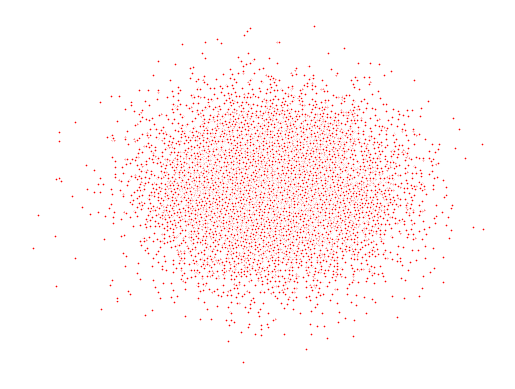

In [22]:
import io
from PIL import Image

imgs = []

for i in range(100):
    plt.clf()
    q_i = q_x(s_curve, np.array([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

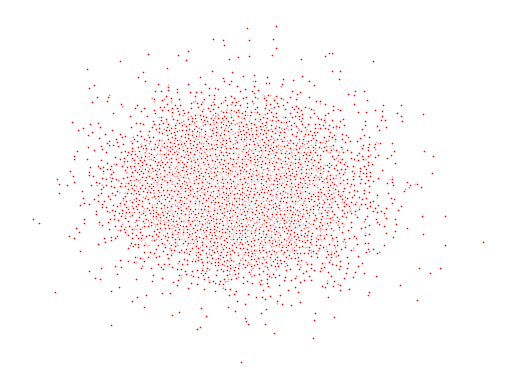

In [23]:
reverse = []

for i in range(100):
    plt.clf()
    cur_x = x_seq[i]
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [24]:
imgs = imgs + reverse
imgs[0].save("diffusion.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)